# Icarus - Generic application for remote sensing

By [Mário de Araújo Carvalho](mailto://mariodearaujocarvalho@gmail.com)

For this project,  we will create an end-to-end Android application with TFLite that will then be open-sourced as a template design pattern.

We opte to develop an **Android application that detects plant Cumbaru**. 


The project is broken down into multiple steps:

* Building and creating a machine learning model using TensorFlow with Keras
* Deploying the model to an Android application using TFLite
* Documenting and open-sourcing the development process






## **Deep Learning  model using Tensorflow with Keras**

We designed algorithms and models to recognize species plant cumbarus in the crop leaves by using Convolutional Neural Network


# **Importing  the Librairies**

In [ ]:
# # Install nightly package for some functionalities that aren't in alpha
# !pip install tensorflow-gpu

# # Install TF Hub for TF2
# !pip install 'tensorflow-hub == 0.7'

# # Install Packaging . 
# !pip install packaging

# # Import OpenCV
# !pip install opencv-python

# # Required to save models in HDF5 format
# !pip install -q pyyaml h5py

# # Optional: Send e-mail when process end
# !pip install yagmail

# # PDF generator and  html
# !pip install WeasyPrint
# !pip install pdfkit


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Desabilitando a GPU
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import numpy as np
import pandas as pd
# Increase precision of presented data for better side-by-side comparison
pd.set_option("display.precision", 8)

import matplotlib.pyplot as plt
from PIL import Image
import datetime
import time
from datetime import datetime
from packaging import version
import sys

# Metrics report

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score, roc_curve

import cv2


# Load the TensorBoard notebook extension
%load_ext tensorboard


# Setup's test of libraries and GPU Support

In [ ]:
"""Don't uncomment this part of code
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
"""
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Verify TensorFlow versionyt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."


Version:  2.0.0
Eager mode:  True
Hub version:  0.7.0
GPU is available


In [ ]:
# GPU informations
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Mar  2 01:59:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:01:00.0  On |                  N/A |
| 31%   47C    P2    35W / 250W |   1086MiB / 12063MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 67.0 gigabytes of available RAM

You are using a high-RAM runtime!


# Setup the experiment


In [ ]:
# %cd ..
!ls

android  assets  dataset  init.sh  notebooks  results


In [ ]:
'''
TRAINED: 
mobilenet_v2_100_224: For this module, the size of the input image is fixed to height x width = 224 x 224
nasnet_mobile: For this module, the size of the input image is fixed to height x width = 224 x 224
inception_resnet_v2: The expected size of the input images is height x width = 299 x 299 pixels by default, but other input sizes are possible (within limits).
inception_v3: The expected size of the input images is height x width = 299 x 299 pixels by default, but other input sizes are possible (within limits).
resnet_v2_50: The expected size of the input images is height x width = 224 x 224 pixels by default, but other input sizes are possible (within limits).
resnet_v2_101: The expected size of the input images is height x width = 224 x 224 pixels by default, but other input sizes are possible (within limits).
resnet_v2_152: The expected size of the input images is height x width = 224 x 224 pixels by default, but other input sizes are possible (within limits).

TRAINING:

NOT TRAIN:
pnasnet_large: The expected size of the input images is height x width = 331 x 331 pixels by default, but other input sizes are possible (within limits).
nasnet_large: The expected size of the input images is height x width = 331 x 331 pixels by default, but other input sizes are possible (within limits).

'''
# Setup of hub 
module_selection = ("inception_resnet_v2", 299) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)

# Setup Image shape and batch size
IMAGE_SHAPE = (pixels, pixels)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 32 # @param {type:"integer"}

# Number of epochs
EPOCHS=30 #@param {type:"integer"}

# Directory root for the experiment
PATH_RESULTS_EXPERIMENT = "results/finalized_results_" + handle_base + "_e" + str(EPOCHS) + "_ft0/"
PATH_RESULT_PDFS = PATH_RESULTS_EXPERIMENT + 'results_html_pdfs/'
PATH_RESULT_EXTRACTED_METRICS = PATH_RESULTS_EXPERIMENT + 'extracted_metrics/'

# Constants
TENSOR_BOARD_NAME_DIRECTORY = PATH_RESULTS_EXPERIMENT + 'logs/log_fit_train/'
TYPE_RUN_CODE = 'GPU'

# Optimizer
LEARNING_RATE = 0.001 #@param {type:"number"}

OPTIMIZER_ADAM = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
OPTIMIZER_SGD = tf.keras.optimizers.SGD(lr=0.005, momentum=0.9)

print(PATH_RESULTS_EXPERIMENT)




results/finalized_results_inception_resnet_v2_e30_ft0/


### Functions util

In [ ]:
def create_directory(dirName):
    # Create target Directory if don't exist
    if not os.path.exists(dirName):
        os.makedirs(dirName)
        print("Directory " , dirName ,  " created.")
    else:    
        print("Directory " , dirName ,  " already exists.")

def save_html_pandas_df(table, name):
    from jinja2 import Environment, FileSystemLoader
    env = Environment(loader=FileSystemLoader('.'))
    template = env.get_template(PATH_RESULTS_EXPERIMENT + "myreport.html")
    template_vars = {"title" : "Cumbarus Detector - National",
                 "national_pivot_table": table.to_html()}
    html_out = template.render(template_vars)

    with open(name, 'w') as f:
      f.write(html_out)
    print('\nCreated a file report in HTML: ', name)

In [ ]:
create_directory(PATH_RESULTS_EXPERIMENT)
create_directory(PATH_RESULT_PDFS)
create_directory(PATH_RESULT_EXTRACTED_METRICS)


file_report_html = PATH_RESULTS_EXPERIMENT + 'myreport.html'
text_html = ""
text_html += "<!DOCTYPE html> \n" 
text_html += "<html> \n" 
text_html += "<head lang=\"en\"> \n" 
text_html += "    <meta charset=\"UTF-8\"> \n" 
text_html += "    <title>{{ title }}</title> \n" 
text_html += "</head> \n"
text_html += "<body> \n"
text_html += "    <h2>Cumbarus Detector - Report</h2> \n" 
text_html += "     <p>{{ national_pivot_table }}</p> \n"
text_html += "</body> \n" 
text_html += "</html>"

with open(file_report_html, 'w') as f:
  f.write(text_html)
print('\nCreated a file report in HTML: ', file_report_html)

Directory  results/finalized_results_inception_resnet_v2_e30_ft0/  already exists.
Directory  results/finalized_results_inception_resnet_v2_e30_ft0/results_html_pdfs/  already exists.
Directory  results/finalized_results_inception_resnet_v2_e30_ft0/extracted_metrics/  already exists.

Created a file report in HTML:  results/finalized_results_inception_resnet_v2_e30_ft0/myreport.html


# Load the data
We will download a public dataset of 1174 images of Dipteryx alata collected under controlled conditions. The images cover 2 trees of crops, including: Dipteryx alata and others tree. .

we'll  need to make sure the input data is resized to 224x224 or 229x229 pixels as required by the networks.



### Prepare training and validation  dataset
Create the training and validation directories 

In [ ]:
# data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
# train_dir = os.path.join(data_dir, 'train')
# validation_dir = os.path.join(data_dir, 'validation')

!ls

data_dir = 'dataset'
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

print('Testing paths:')
print('Train: ', train_dir)
print('Val: ', validation_dir)
print('Test: ', test_dir)


android  assets  dataset  init.sh  notebooks  results
Testing paths:
Train:  dataset/train
Val:  dataset/val
Test:  dataset/test


In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + " files"


In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))
print('total images for testing :', count(test_dir))


total images for training : dataset/train : 1409 files
total images for validation : dataset/val : 470 files
total images for testing : dataset/test : 470 files


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. 

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).



In [ ]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.
 
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)
 
testing_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
testing_generator = testing_datagen.flow_from_directory(
    test_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)
 
do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=20,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2)
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

Found 470 images belonging to 2 classes.
Found 470 images belonging to 2 classes.
Found 1409 images belonging to 2 classes.


In [ ]:

print('Total images: ',str(704 + 470))

1174

### Visualize training images

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

In [ ]:
sample_training_images, _ = next(train_generator)

The next function returns a batch from the dataset. The return value of next function is in form of (x_train, y_train) where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

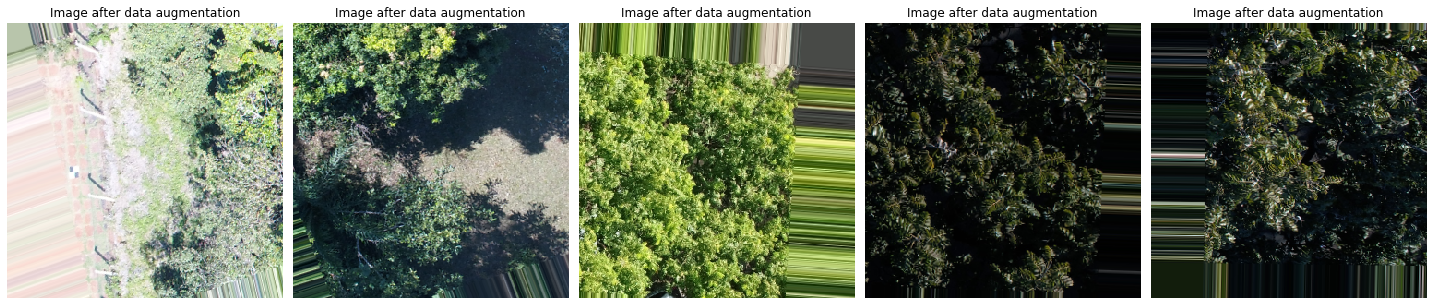

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title('Image after data augmentation')
    plt.tight_layout()
    # plt.show()
    plt.savefig(PATH_RESULT_PDFS + TYPE_RUN_CODE + '_result_data_augmentation_training_predict.pdf")
# plot images
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `labels.txt`.

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open(PATH_RESULTS_EXPERIMENT + 'labels.txt', 'w') as f:
  f.write(labels)

{'cumbaru': 0, 'outra': 1}


In [ ]:
!cat {PATH_RESULTS_EXPERIMENT}labels.txt

cumbaru
outra

In [ ]:
print('Number of classes:',train_generator.num_classes)

Number of classes: 2


### Definition a function for create model    


In [ ]:
# Handle (URL) of TF_HUB, Do fine tuning, momentum
def create_model(handle, do_fine_tuning, momentum = 0.99):
    print("Building model. Using {} with input size {}".format(handle, IMAGE_SIZE))

    model = tf.keras.Sequential([
        hub.KerasLayer(handle, trainable=do_fine_tuning),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                              kernel_regularizer=tf.keras.regularizers.l2(0.0001))
    ])
    model.build((None,)+IMAGE_SIZE+(3,))
    model.summary()
    return model


### Build the model for training
All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [ ]:
# My model of not FINE_TUNING
model = create_model(MODULE_HANDLE, False)

Building model. Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_6 (Dropout)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  655872    
_________________________________________________________________
dropout_7 (Dropout)          multiple                  0         
_________________________________________________________________
dense_7 (Dense)              multiple                  1026      
Total params: 2,914,882
Trainable params: 656,898
Non-trainable params: 2,257,984
_________________________________________________

## Compile model: Specify Loss Function and Optimizer

In [ ]:
METRICS = [
      tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
      tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error")
]
'''
Understanding useful metrics
Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.

False negatives and false positives: Are samples that were incorrectly classified
True negatives and true positives: Are samples that were correctly classified
Accuracy: Is the percentage of examples correctly classified > 
Precision: Is the percentage of predicted positives that were correctly classified > 
Recall: Is the percentage of actual positives that were correctly classified > 
AUC: Refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than than a random negative sample.
'''
x_var_t = 5

In [ ]:
# Compile model specifying the optimizer learning rate
model.compile(
   optimizer=OPTIMIZER_ADAM, 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

# Train Model
train model using validation dataset for validate each steps

In [ ]:
print('train.size: %.2f' % train_generator.batch_size)
print('train.samples: %.2f' % train_generator.samples)
print('train-size/samples: %.2f' % (train_generator.samples//train_generator.batch_size))
print('\n')
print('val.size: %.2f' % validation_generator.batch_size)
print('val.samples: %.2f' % validation_generator.samples)
print('val-size/samples: %.2f' % (validation_generator.samples//validation_generator.batch_size))

train.size: 64.00
train.samples: 1409.00
train-size/samples: 22.00


val.size: 64.00
val.samples: 470.00
val-size/samples: 7.00


In [ ]:
# setub callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=TENSOR_BOARD_NAME_DIRECTORY, histogram_freq=1)

In [ ]:
# Train the model
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs= 2, # EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        callbacks=[tensorboard_callback])

 1/22 [>.............................] - ETA: 58s - loss: 0.0771 - tp: 63.0000 - fp: 1.0000 - tn: 63.0000 - fn: 1.0000 - accuracy: 0.9844 - precision: 0.9844 - recall: 0.9844 - auc: 0.9993 - binary_accuracy: 0.9844WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.788766). Check your callbacks.


22/22 [==============================] - 71s 3s/step - loss: 0.1669 - tp: 1253.0000 - fp: 92.0000 - tn: 1253.0000 - fn: 92.0000 - accuracy: 0.9316 - precision: 0.9316 - recall: 0.9316 - auc: 0.9816 - binary_accuracy: 0.9316 - val_loss: 0.1388 - val_tp: 424.0000 - val_fp: 24.0000 - val_tn: 424.0000 - val_fn: 24.0000 - val_accuracy: 0.9464 - val_precision: 0.9464 - val_recall: 0.9464 - val_auc: 0.9882 - val_binary_accuracy: 0.9464


In [ ]:
%tensorboard --logdir "{TENSOR_BOARD_NAME_DIRECTORY}"

Reusing TensorBoard on port 6007 (pid 21885), started 0:40:59 ago. (Use '!kill 21885' to kill it.)

## Export as saved model
Now that you've trained the model, export it as a saved model

In [ ]:
export_path_tf = PATH_RESULTS_EXPERIMENT + "saved_models/{}".format(handle_base)
print('Path of TF Savd Model: ',export_path_tf)

Path of TF Savd Model:  results/finalized_results_inception_resnet_v2_e30_ft0/saved_models/inception_resnet_v2


In [ ]:
# Save the model in tensorflow format
tf.keras.models.save_model(model, export_path_tf, save_format='tf')

# tf.keras.experimental.export_saved_model(model, export_path)

print(export_path_tf)
print('Export the saved model successful!')

## Reloaded the saved model


In [ ]:
# %cd ..
!ls

android  assets  dataset  init.sh  notebooks  results


In [ ]:
# Now confirm that we can reload it, and it still gives the same results
# reloaded = tf.keras.models.load_model(export_path_tf, custom_objects={'KerasLayer':hub.KerasLayer})

reloaded = tf.keras.experimental.load_from_saved_model(export_path_tf, custom_objects={'KerasLayer':hub.KerasLayer})

print(reloaded.get_config())

# Get input shape from model.get_config()
reloaded.summary()
print('Reloaded the saved model successful!')


Instructions for updating:
The experimental save and load functions have been  deprecated. Please switch to `tf.keras.models.load_model`.
{'name': 'sequential', 'layers': [{'class_name': 'KerasLayer', 'config': {'name': 'keras_layer', 'trainable': False, 'dtype': 'float32', 'handle': 'https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4'}}, {'class_name': 'Dropout', 'config': {'name': 'dropout', 'trainable': True, 'dtype': 'float32', 'rate': 0.4, 'noise_shape': None, 'seed': None}}, {'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 512, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dropout', 'config': {'name': 'dropout_1', 'trainable': 

In [ ]:
reloaded.compile(optimizer=OPTIMIZER_ADAM, 
              loss='categorical_crossentropy', 
              metrics=['accuracy']) # ['accuracy']

val_steps_per_epoch = np.ceil(testing_generator.samples//testing_generator.batch_size)
# final_loss, final_accuracy 
# Measure accuracy and loss after training
result_evaluate = reloaded.evaluate(testing_generator, steps = val_steps_per_epoch)

14/14 [==============================] - 20s 1s/step - loss: 0.0139 - accuracy: 1.0000


In [ ]:
'''
result_evaluate = [loss, 
                   accuracy,
                   tp,
                   fp,
                   tn,
                   fn,
                   precision,
                   recall,
                   auc,
                   binary_accuracy,
                   root_mean_squared_error]
'''
print('Final loss: ', result_evaluate[0])
print('Final accuracy: ', result_evaluate[1])
final_loss = result_evaluate[0]
final_accuracy = result_evaluate[1]

Final loss:  0.013936076770603125
Final accuracy:  1.0


In [ ]:
text_final_acc = 'Evaluate set testing_generator: '
text_final_acc += "\nFinal loss (testing_generator): {:.24}".format(final_loss)
text_final_acc += "\nFinal accuracy(testing_generator) : {:.4f}%".format(final_accuracy * 100)

print(text_final_acc)

with open(PATH_RESULT_EXTRACTED_METRICS + TYPE_RUN_CODE + '_result_of_final_loss_accuracy_.txt', 'w') as f:
  f.write(text_final_acc)

print('\nMetrics save successful!')

Evaluate set testing_generator: 
Final loss (testing_generator): 0.0139360767706031250801058
Final accuracy(testing_generator) : 100.0000%

Metrics save successful!


## Convert model to TFLite

Convert recently loaded model to TensorFlow Lite models (standard and quantized with a [post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization)).

Because of TensorFlow 2.0 nature, we'll need to convert TensorFlow model into concrete function and then do conversion to TFLite. More about it [here](https://www.tensorflow.org/lite/r2/convert/concrete_function).

In [ ]:
PATH_TFLITE_EXPORT = PATH_RESULTS_EXPERIMENT + "tflite_models/"
create_directory(PATH_TFLITE_EXPORT)

TFLITE_MODEL = PATH_TFLITE_EXPORT + "cumbarus_detector_model.tflite"
TFLITE_QUANT_MODEL = PATH_TFLITE_EXPORT + "cumbarus_detector_model_quant.tflite"


Directory  results/finalized_results_inception_resnet_v2_e30_ft0/tflite_models/  already exists.


In [ ]:
# convert the model to TFLite

# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(reloaded.inputs[0].shape, reloaded.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)
print("SUCCESS: Model exported fot TFLITE FORMAT in path: " + TFLITE_MODEL)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("SUCCESS: Model exported fot TFLITE QUANTIZED FORMAT in path: " + TFLITE_QUANT_MODEL)


SUCCESS: Model exported fot TFLITE FORMAT in path: results/finalized_results_inception_resnet_v2_e30_ft0/tflite_models/cumbarus_detector_model.tflite
SUCCESS: Model exported fot TFLITE QUANTIZED FORMAT in path: results/finalized_results_inception_resnet_v2_e30_ft0/tflite_models/cumbarus_detector_model_quant.tflite


### Check Performance - Train
#### Plot training and validation accuracy and loss

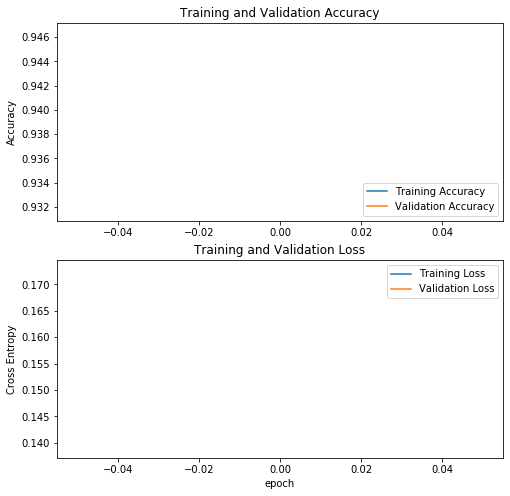

In [ ]:
# The returned "history" object holds a record
# of the loss values and metric values during training
with open(PATH_RESULTS_EXPERIMENT + 'history_train_history.txt', 'w') as f:
  f.write(str(history.history))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(PATH_RESULTS_EXPERIMENT + "results_train_acc_loss.png")

# plt.show()

# Get metrics of model reloaded

### Methods to load and predict the image

In [ ]:
target_classes_names = ['Cumbaru', 'Outra']

def load_image(filename):
    img = cv2.imread(filename)
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
    img = img /255
    
    return img

def predict(image):
    ti = time.time()
    probabilities = reloaded.predict(np.asarray([image]))[0]
    t = time.time() - ti
    class_idx = np.argmax(probabilities)
    class_label = {target_classes_names[class_idx]: probabilities[class_idx]}
    
    return class_label, t

## Test Model for one image


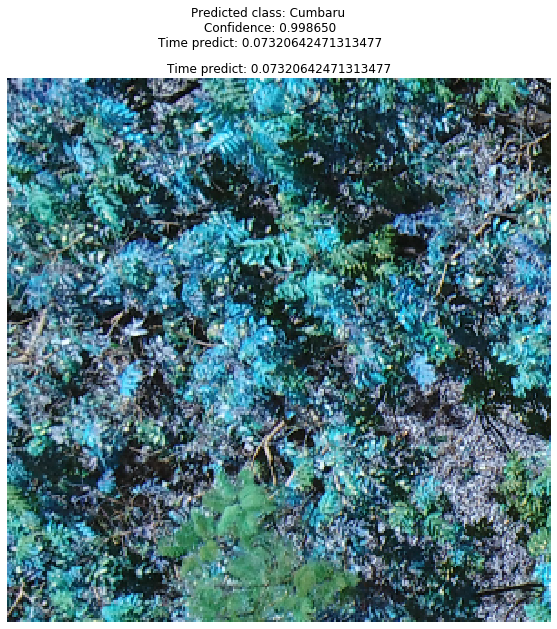

In [ ]:
# Set path the image
# img_path = 'dataset/test/outra/DJI_0577_2048_1024.png'
img_path = 'dataset/test/cumbaru/cumbaru_foto_vant6_folder_train_0_0.png'

# Load image
img = load_image(img_path)
# print(img)

#Predict image
prediction, time_predited = predict(img)

title_text  = "Predicted class: %s \nConfidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0])
title_text += "\nTime predict: " + str(time_predited) 
subtitle_text = "Time predict: " + str(time_predited) 

# print(title_text)

plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.2)

plt.imshow(img)
plt.title(subtitle_text)
plt.axis('off')
_ = plt.suptitle(title_text)

plt.savefig(PATH_RESULT_PDFS + TYPE_RUN_CODE + "_result_test_one_image_tf_model_testing_predict.pdf")

## TF Model: Predicting all images the folder test
Sample images from testing dataset and predict

In [ ]:
# Predicting all images of dataset test

# Arrays helpers for the get metrics
y_true = []
y_pred = []

# List of time images predicteds
times_of_predictions = []

# Path to folders test
paths = [test_dir + '/cumbaru', test_dir + '/outra']

# Hits of errors - Cumbaru
cumbaru_list_hits = []
cumbaru_list_errors = []

# Hits of errors - Outra
outra_list_hits = []
outra_list_errors = []

# Init progress bar in terminal
sys.stdout.write("[")

#  For i in paths folders of imagens
for i in range(len(paths)):
    # Get list of all images file in the folder
    files_images = [f for f in os.listdir(paths[i]) if f.endswith('png')]
    
    print('\nPredicting', len(files_images), 'images in folder: ', paths[i])
    
    # For i in all images paths
    for filename in files_images:
        # Load image
        img = load_image(os.path.join(paths[i], filename))
        
        # Predict image and get label class and time predict
        prediction, time_predicted= predict(img)
        
        # Append the time in list of times
        times_of_predictions.append(time_predicted)
        
        # print("Class predicted: %s \nConfidence: %f  \nPath: %s" % (list(prediction.keys())[0], list(prediction.values())[0], os.path.join(paths[i], filename)))
        y_true.append(i)
        
        # Class label predict x
        classe_predict = list(prediction.keys())[0]
        
        if (classe_predict == 'Cumbaru'):
            y_pred.append(0)
        else:
            y_pred.append(1)
            
        # Get images of error hit
        if (i == 0): # Cumbaru
            if (classe_predict == 'Cumbaru'):
                 cumbaru_list_hits.append(paths[0] + '/' + filename)
            elif (classe_predict == "Outra"):
                cumbaru_list_errors.append(paths[0] + '/' + filename)
                
        elif (i == 1): # Outra
            if (classe_predict == 'Outra'):
                 outra_list_hits.append(paths[1] + '/' + filename)
            elif (classe_predict == "Cumbaru"):
                outra_list_errors.append(paths[1] + '/' + filename)
        
        # Set progress bar in terminal
        sys.stdout.write("#")
        sys.stdout.flush()
        
# Finilize the progress bar
sys.stdout.write("]\n") # this ends the progress bar
print('Predictions successfully completed in foldes: ', paths)


[
Predicting 254 images in folder:  dataset/test/cumbaru
##############################################################################################################################################################################################################################################################
Predicting 216 images in folder:  dataset/test/outra
################################################################################################################################

### Get confusion matriz, meam,  standard deviation 

In [ ]:
confusion_matrix_table = confusion_matrix(y_true, y_pred)
print ('Confusion Matrix Table: \n',confusion_matrix_table)

# As a matter of good practice, the first element is deleted.
times_of_predictions = times_of_predictions[1:]

## Calculation averages of time
average_time = np.mean(times_of_predictions)
std_time = np.std(times_of_predictions)
print('Average time:', average_time)
print('Standard Deviation of time:', std_time)

### Geta all metrics avaluation and time statistics
Jaccard, Log loss, ROC AUC, AUC, mean time, standard deviation time

In [ ]:
result_metrics = classification_report(y_true, y_pred, target_names=target_classes_names)

# metric_jaccard_sim_coef = jaccard_score(y_true, y_pred, average=None)
# metric_log_loss = log_loss(y_true, y_pred)

metric_roc_auc_score = roc_auc_score(y_true, y_pred)
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
metric_auc = auc(fpr, tpr)

# result_metrics += '\nCoeficiente de similaridade de Jaccard : ' + str(metric_jaccard_sim_coef)
# result_metrics += '\nLog Loss : ' + str(metric_log_loss)

result_metrics += '\nROC AUC score : ' + str(metric_roc_auc_score)
result_metrics += '\nAUC : ' + str(metric_auc)
result_metrics += '\nConfusion Matrix Table: \n' + str(confusion_matrix_table)
result_metrics += '\nAverage time: %.4f' % (average_time)
result_metrics += '\nStandard Deviation of time: %.4f' %  (std_time)

print(result_metrics)
report_metrics = PATH_RESULT_EXTRACTED_METRICS + TYPE_RUN_CODE + '_final_TF_MODEL_metrics_report.txt'
with open(report_metrics, 'w') as f:
  f.write(str(result_metrics))
print('\nResult data metrics has been successfully saved in: ', report_metrics)


### Generate simbolics link for the images predict errors and hit


In [ ]:
def simbolics_link(name, classe, path, list_data):
    text = "Class %s - path %s\n["%(classe, path)
    sys.stdout.write(text)
    for filename in list_data:

        # Source file path 
        src = os.path.abspath(filename)
        # Destination file path 
        _, ext = os.path.splitext(filename)
        tail = os.path.splitext(os.path.basename(filename))[0]

        dst = PATH_RESULTS_EXPERIMENT + TYPE_RUN_CODE + '_testing_results/%s/%s/%s/'%(name, classe, path) + tail + '(symlink)' + ext
        # Create a symbolic link 
        # pointing to src named dst 
        # using os.symlink() method
        try:
            os.symlink(src, dst)
        except FileExistsError:
            print('\nThe simbolic link when that file already exists, removing the file and creating a new file: %s'%(filename))
            os.remove(dst)
            os.symlink(src, dst)
            pass
        sys.stdout.write("#")
        sys.stdout.flush()
    sys.stdout.write("]\n") # this ends the progress bar
    
name = 'TF_MODEL'
simlinks_path = ['errors', 'hits']
for classe in target_classes_names:
    path_error = PATH_RESULTS_EXPERIMENT + TYPE_RUN_CODE + '_testing_results/%s/%s/errors'%(name,classe)
    path_hit = PATH_RESULTS_EXPERIMENT + TYPE_RUN_CODE + '_testing_results/%s/%s/hits'%(name,classe)
    create_directory(path_error)
    create_directory(path_hit)
    for path in simlinks_path:
        if (classe == target_classes_names[0] and path == 'errors'):
            simbolics_link(name, classe, path, cumbaru_list_errors)
        elif (classe == target_classes_names[0] and path == 'hits'):
            simbolics_link(name, classe, path, cumbaru_list_hits)
        elif (classe == target_classes_names[1] and path == 'hits'):
            simbolics_link(name, classe, path, outra_list_hits)
        elif (classe == target_classes_names[1] and path == 'errors'):
            simbolics_link(name, classe, path, outra_list_errors)
print('\nAll simbolics links are created successfully!')
name = ''

Directory  results/finalized_results_inception_resnet_v2_e30_ft0/GPU_testing_results/TF_MODEL/Cumbaru/errors  created.
Directory  results/finalized_results_inception_resnet_v2_e30_ft0/GPU_testing_results/TF_MODEL/Cumbaru/hits  created.
Class Cumbaru - path errors
[#]
Class Cumbaru - path hits
[#############################################################################################################################################################################################################################################################]
Directory  results/finalized_results_inception_resnet_v2_e30_ft0/GPU_testing_results/TF_MODEL/Outra/errors  created.
Directory  results/finalized_results_inception_resnet_v2_e30_ft0/GPU_testing_results/TF_MODEL/Outra/hits  created.
Class Outra - path errors
[################]
Class Outra - path hits
[####################################################################################################################################################

### Get matrix of result the predictions

In [ ]:
label_ids = y_pred
# Get labels
label_map = (testing_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
label_name = [label_map[k] for k in label_ids]

text_full = '\npredicted_ids: \n' + str(label_ids)
text_full += '\nlabel_map: \n' + str(label_map)
text_full += '\nlabel_name: \n' + str(label_name)
print(text_full)
with open(PATH_RESULT_EXTRACTED_METRICS + TYPE_RUN_CODE + '_result_matrix_of_predict_generator.txt', 'w') as f:
  f.write(str(text_full))



predicted_ids: 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

## Load TensorFlow lite model with interpreter interface.

## Load TFLite Model for predictions

Load TensorFlow lite model with interpreter interface.

In [ ]:
interpreters = []

# Load TFLite model and see some details about input/output

tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

interpreters.append(['TF_LITE_MODEL',tflite_interpreter, input_details, output_details])

== Input details ==
name: x
shape: [  1 299 299   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [1 2]
type: <class 'numpy.float32'>


## Load TFLite Quantized Model for predictions

Load TensorFlow lite model with interpreter interface.
#### Now let's do the same for TFLite quantized model:
- Load model,
- Reshape input to handle batch of images,
- Run prediction

In [ ]:
# Load quantized TFLite model

tflite_interpreter_quant = tf.lite.Interpreter(model_path=TFLITE_QUANT_MODEL)
tflite_interpreter_quant.allocate_tensors()

# Learn about its input and output details
input_details = tflite_interpreter_quant.get_input_details()
output_details = tflite_interpreter_quant.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])


interpreters.append(['TF_LITE_QUANTIZED_MODEL',tflite_interpreter_quant, input_details, output_details])

== Input details ==
name: x
shape: [  1 299 299   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [1 2]
type: <class 'numpy.float32'>


# Run prediction in one image

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
# tf.keras.applications.inception_resnet_v2.preprocess_input
from tensorflow.keras.preprocessing import image

for i in interpreters: 
    name, interpreter, input_details, output_details = i
    print('Running: ', name)
    
    # Predicting one image of dataset test
    # Load image
    img_path = 'dataset/test/cumbaru/cumbaru_foto_vant6_folder_train_0_0.png'
    img_path = 'dataset/test/outra/DJI_0577_2048_1024.png'
    img_path = 'dataset/test/outra/DJI_0448_1024_0.png'
    img_path = 'dataset/test/outra/DJI_0472_1024_2048.png'

    # Convert image in Array
   
    img2 = cv2.imread(img_path)
    # change the dtype to 'float64' 
    img2 = img2.astype('float32') 
    img2 = cv2.resize(img2, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
    img2 = img2 / 255
    img2 = np.expand_dims(img2, axis=0)
    # print(img2)


    # Test model on random input data.
    input_shape = input_details[0]['shape']
    input_data = img2


    ti = time.time()
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    time_predicted = time.time() - ti

    probabilities = output_data[0]

    class_idx = np.argmax(probabilities)
    prediction = {target_classes_names[class_idx]: probabilities[class_idx]}

    print("Class predicted: %s \nConfidence: %f  \nPath: %s" % (list(prediction.keys())[0], list(prediction.values())[0], img_path))
    print('Time of prediction inference: ', '{0:.6f}'.format(time_predicted),'\n')



Running:  TF_LITE_MODEL
Class predicted: Outra 
Confidence: 0.984554  
Path: dataset/test/outra/DJI_0472_1024_2048.png
Time of prediction inference:  0.205451 

Running:  TF_LITE_QUANTIZED_MODEL
Class predicted: Outra 
Confidence: 0.997866  
Path: dataset/test/outra/DJI_0472_1024_2048.png
Time of prediction inference:  2.026770 



# Run predicitions in all folder test

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image

for i in interpreters: 
    name, interpreter, input_details, output_details = i
    print('Running: ', name)
    
    # Predicting all images of dataset test

    # Arrays helpers for the get metrics
    y_true = []
    y_pred = []

    # List of time images predicteds
    times_of_predictions = []

    # Path to folders test
    paths = [test_dir + '/cumbaru', test_dir + '/outra']

    # Hits of errors - Cumbaru
    cumbaru_list_hits = []
    cumbaru_list_errors = []

    # Hits of errors - Outra
    outra_list_hits = []
    outra_list_errors = []

    # Init progress bar in terminal
    sys.stdout.write("[")
    #  For i in paths folders of imagens
    for i in range(len(paths)):
        # Get list of all images file in the folder
        files_images = [f for f in os.listdir(paths[i]) if f.endswith('png')]

        print('\nPredicting', len(files_images), 'images in folder: ', paths[i])

        # For i in all images paths
        for filename in files_images:
            # Load image
            img_path = os.path.join(paths[i], filename)
            
            # Convert image in Array
            img2 = cv2.imread(img_path)
            # change the dtype to 'float64' 
            img2 = img2.astype('float32') 
            img2 = cv2.resize(img2, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
            img2 = img2 / 255
            img2 = np.expand_dims(img2, axis=0)
            
            # Test model on random input data.
            input_shape = input_details[0]['shape']
            input_data = img2
            
            ti = time.time()
            interpreter.set_tensor(input_details[0]['index'], input_data)

            interpreter.invoke()

            # The function `get_tensor()` returns a copy of the tensor data.
            # Use `tensor()` in order to get a pointer to the tensor.
            output_data = interpreter.get_tensor(output_details[0]['index'])
            time_predicted = time.time() - ti
            # print('Time of prediction inference: ', '{0:.6f}'.format(t))

            probabilities = output_data[0]

            class_idx = np.argmax(probabilities)
            prediction = {target_classes_names[class_idx]: probabilities[class_idx]}

            ##

            # Append the time in list of times
            times_of_predictions.append(time_predicted)

            # print("Class predicted: %s \nConfidence: %f  \nPath: %s" % (list(prediction.keys())[0], list(prediction.values())[0], os.path.join(paths[i], filename)))
            y_true.append(i)

            # Class label predict
            classe_predict = list(prediction.keys())[0]

            if (classe_predict == 'Cumbaru'):
                y_pred.append(0)
            else:
                y_pred.append(1)

            # Get images of error hit
            if (i == 0): # Cumbaru
                if (classe_predict == 'Cumbaru'):
                     cumbaru_list_hits.append(paths[0] + '/' + filename)
                elif (classe_predict == "Outra"):
                    cumbaru_list_errors.append(paths[0] + '/' + filename)

            elif (i == 1): # Outra
                if (classe_predict == 'Outra'):
                     outra_list_hits.append(paths[1] + '/' + filename)
                elif (classe_predict == "Cumbaru"):
                    outra_list_errors.append(paths[1] + '/' + filename)

            # Set progress bar in terminal
            sys.stdout.write("#")
            sys.stdout.flush()

    # Finilize the progress bar
    sys.stdout.write("]\n") # this ends the progress bar
    print('Predictions successfully completed in foldes: ', paths)
    
    # Get metrics
    confusion_matrix_table = confusion_matrix(y_true, y_pred)
    print ('Confusion Matrix Table: \n',confusion_matrix_table)

    # As a matter of good practice, the first element is deleted.
    times_of_predictions = times_of_predictions[1:]

    ## Calculation averages of time
    average_time = np.mean(times_of_predictions)
    std_time = np.std(times_of_predictions)
    print('Average time:', average_time)
    print('Standard Deviation of time:', std_time)

    result_metrics = classification_report(y_true, y_pred, target_names=target_classes_names)

    # metric_jaccard_sim_coef = jaccard_score(y_true, y_pred, average=None)
    # metric_log_loss = log_loss(y_true, y_pred)

    metric_roc_auc_score = roc_auc_score(y_true, y_pred)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
    metric_auc = auc(fpr, tpr)

    # result_metrics += '\nCoeficiente de similaridade de Jaccard : ' + str(metric_jaccard_sim_coef)
    # result_metrics += '\nLog Loss : ' + str(metric_log_loss)

    result_metrics += '\nROC AUC score : ' + str(metric_roc_auc_score)
    result_metrics += '\nAUC : ' + str(metric_auc)
    result_metrics += '\nConfusion Matrix Table: \n' + str(confusion_matrix_table)
    result_metrics += '\nAverage time: %.14f' % (average_time)
    result_metrics += '\nStandard Deviation of time: %.14f' %  (std_time)

    print(result_metrics)
    report_metrics = PATH_RESULT_EXTRACTED_METRICS + TYPE_RUN_CODE + '_final_'+name+'_metrics_report.txt'
    with open(report_metrics, 'w') as f:
      f.write(str(result_metrics))
    print('\nResult data metrics has been successfully saved in: ', report_metrics)
    
    def simbolics_link(name, classe, path, list_data):
        text = "Class %s - path %s\n["%(classe, path)
        sys.stdout.write(text)
        for filename in list_data:

            # Source file path 
            src = os.path.abspath(filename)
            # Destination file path 
            _, ext = os.path.splitext(filename)
            tail = os.path.splitext(os.path.basename(filename))[0]

            dst = PATH_RESULTS_EXPERIMENT + TYPE_RUN_CODE + '_testing_results/%s/%s/%s/'%(name,classe, path) + tail + '(symlink)' + ext
            # Create a symbolic link 
            # pointing to src named dst 
            # using os.symlink() method
            try:
                os.symlink(src, dst)
            except FileExistsError:
                print('\nThe simbolic link when that file already exists, removing the file and creating a new file: %s'%(filename))
                os.remove(dst)
                os.symlink(src, dst)
                pass
            sys.stdout.write("#")
            sys.stdout.flush()
        sys.stdout.write("]\n") # this ends the progress bar

    simlinks_path = ['errors', 'hits']
    for classe in target_classes_names:
        path_error = PATH_RESULTS_EXPERIMENT + TYPE_RUN_CODE + '_testing_results/%s/%s/errors'%(name,classe)
        path_hit = PATH_RESULTS_EXPERIMENT + TYPE_RUN_CODE + '_testing_results/%s/%s/hits'%(name,classe)
        create_directory(path_error)
        create_directory(path_hit)
        for path in simlinks_path:
            if (classe == target_classes_names[0] and path == 'errors'):
                simbolics_link(name, classe, path, cumbaru_list_errors)
            elif (classe == target_classes_names[0] and path == 'hits'):
                simbolics_link(name,classe, path, cumbaru_list_hits)
            elif (classe == target_classes_names[1] and path == 'hits'):
                simbolics_link(name,classe, path, outra_list_hits)
            elif (classe == target_classes_names[1] and path == 'errors'):
                simbolics_link(name,classe, path, outra_list_errors)
    print('\nAll simbolics links are created successfully!')

    

Running:  TF_LITE_MODEL
[
Predicting 254 images in folder:  dataset/test/cumbaru
##############################################################################################################################################################################################################################################################
Predicting 216 images in folder:  dataset/test/outra
########################################################################################################################################################################################################################]
Predictions successfully completed in foldes:  ['dataset/test/cumbaru', 'dataset/test/outra']
Confusion Matrix Table: 
 [[253   1]
 [ 16 200]]
Average time: 0.17966709563981242
Standard Deviation of time: 0.018419407177175173
              precision    recall  f1-score   support

     Cumbaru       0.94      1.00      0.97       254
       Outra       1.00      0.93      0.96       216

   

## Export image validation batch
Export validation batch so it can be tested client side. Below we create compressed file containing all images named with the convention:

`n{}_true{}_pred{}.jpg`

where the first number is index, the second - true label index, the third - value predicted by TFLite moder generated in this notebook. Example file will look similar to this: `n0_true1_pred1.jpg`.

All images then will be put into client side testing code (res/assets in Android tests). Integration tests will run inference process on each image and then compare results with the ones saved in file names.

In [ ]:
VAL_BATCH_DIR = PATH_RESULTS_EXPERIMENT + TYPE_RUN_CODE + '_testing_results/validation_batch"
create_directory(VAL_BATCH_DIR)

# Export batch to *.jpg files with specific naming convention.
# Make sure they are exported in the full quality, otherwise the inference
# process will return different results. 

for n in range(16):
  filename = "n{:0.0f}_true{:0.0f}_pred{:0.0f}.jpg".format(
      n,
      true_label_ids[n],
      tflite_model_pred_simplified[n][0]
  )
  img_arr = np.copy(val_image_batch[n])
  img_arr *= 255
  img_arr = img_arr.astype("uint8")
  img11 = Image.fromarray(img_arr, 'RGB')
  img11.save("{}/{}".format(VAL_BATCH_DIR, filename), "JPEG", quality=100)

## CONCLUSION
The model can be improved if you change some hyperparameters. You can try using a different pretrained model. It's up to you. Let me know if you can improve the accuracy! Let's develop an Android app that uses this model.

## SEND EMAIL FOR CONCLUSION
Send the email for me. 

In [ ]:
# pip install yagmail
 
import yagmail
from datetime import datetime
 
x = datetime.now().strftime('%d/%m/%Y %H:%M')
 
yag = yagmail.SMTP('domain@email.com', 'password')
 
contents = ["Olá, Mário. O seu treinamento da rede %s foi concluído com sucesso. Parabéns!" % (handle_base)]
 
yag.send('mariodearaujocarvalho@gmail.com', 'Aviso (IA): Treinamento finalizado em %s' % x, contents)